<a href="https://colab.research.google.com/github/sudharshan-Bathini/credit_card_fraud_detection/blob/main/dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import deque
import random


In [19]:
class FraudDetectionEnv(gym.Env):
    def __init__(self, data_file):
        super(FraudDetectionEnv, self).__init__()
        self.data = pd.read_csv(data_file)

        # Ensure proper numeric conversion
        self.data = self.data.select_dtypes(include=[np.number])

        self.scaler = StandardScaler()
        self.data.iloc[:, :-1] = self.scaler.fit_transform(self.data.iloc[:, :-1])

        self.state_idx = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.data.shape[1] - 1,), dtype=np.float32)

    def reset(self):
        self.state_idx = 0
        return self.data.iloc[self.state_idx, :-1].values

    def step(self, action):
        reward = 1 if action == self.data.iloc[self.state_idx, -1] else -1
        self.state_idx += 1
        done = self.state_idx >= len(self.data)
        next_state = self.data.iloc[self.state_idx, :-1].values if not done else np.zeros(self.observation_space.shape)
        return next_state, reward, done, {}

# Initialize the environment
env = FraudDetectionEnv('credit_card_fraud_dataset.csv')


<ipython-input-19-26bcbc1eeba4>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.73203349 -1.73199885 -1.73196421 ...  1.73196421  1.73199885
  1.73203349]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.iloc[:, :-1] = self.scaler.fit_transform(self.data.iloc[:, :-1])
<ipython-input-19-26bcbc1eeba4>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.64535719 -1.3600847  -0.37295009 ...  0.65228445  0.49295746
  0.60033   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.iloc[:, :-1] = self.scaler.fit_transform(self.data.iloc[:, :-1])


In [20]:
class DQN(nn.Module):
    def __init__(self, input_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 18)
        self.fc3 = nn.Linear(18, 20)
        self.fc4 = nn.Linear(20, 24)
        self.fc5 = nn.Linear(24, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x


In [21]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return torch.tensor(states, dtype=torch.float32).to(device), \
               torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device), \
               torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device), \
               torch.tensor(next_states, dtype=torch.float32).to(device), \
               torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

    def __len__(self):
        return len(self.memory)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent:
    def __init__(self, input_dim, action_size, seed):
        self.action_size = action_size
        self.qnet_local = DQN(input_dim).to(device)
        self.qnet_target = DQN(input_dim).to(device)
        self.optimizer = optim.Adam(self.qnet_local.parameters(), lr=0.001)
        self.memory = ReplayBuffer(action_size, buffer_size=100000, batch_size=64, seed=seed)
        self.train_loss = []

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > 64:
            experiences = self.memory.sample()
            self.learn(experiences)

    def epsilon_greedy_action(self, state, epsilon=0.1):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = self.qnet_local(state)
        if random.random() > epsilon:
            return action_values.max(1)[1].item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma=0.99):
        states, actions, rewards, next_states, dones = experiences
        criterion = nn.MSELoss()

        q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        q_expected = self.qnet_local(states).gather(1, actions)
        loss = criterion(q_expected, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_loss.append(loss.item())


In [23]:
agent = Agent(input_dim=env.observation_space.shape[0], action_size=2, seed=0)

num_episodes = 10
for i in range(num_episodes):
    state = env.reset()
    for _ in range(1000):
        action = agent.epsilon_greedy_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break


<ipython-input-21-1e4193eaffa3>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(states, dtype=torch.float32).to(device), \


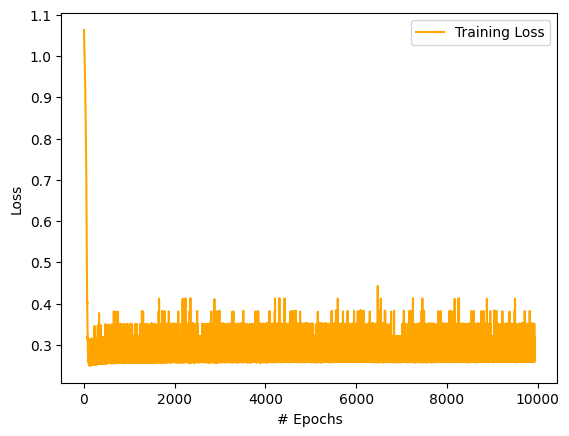

In [24]:
plt.plot(range(len(agent.train_loss)), agent.train_loss, color='orange', label='Training Loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
correct = 0
total = len(env.data)

with torch.no_grad():
    for i in range(total):
        state = env.data.iloc[i, :-1].values
        label = env.data.iloc[i, -1]
        action = agent.epsilon_greedy_action(state)
        correct += (action == label)

accuracy = (correct / total) * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 94.08%
